In [164]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [165]:
# This sets up the figure size
plt.rcParams['figure.figsize'] = [6, 6]

In [166]:
data = pd.read_csv('jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


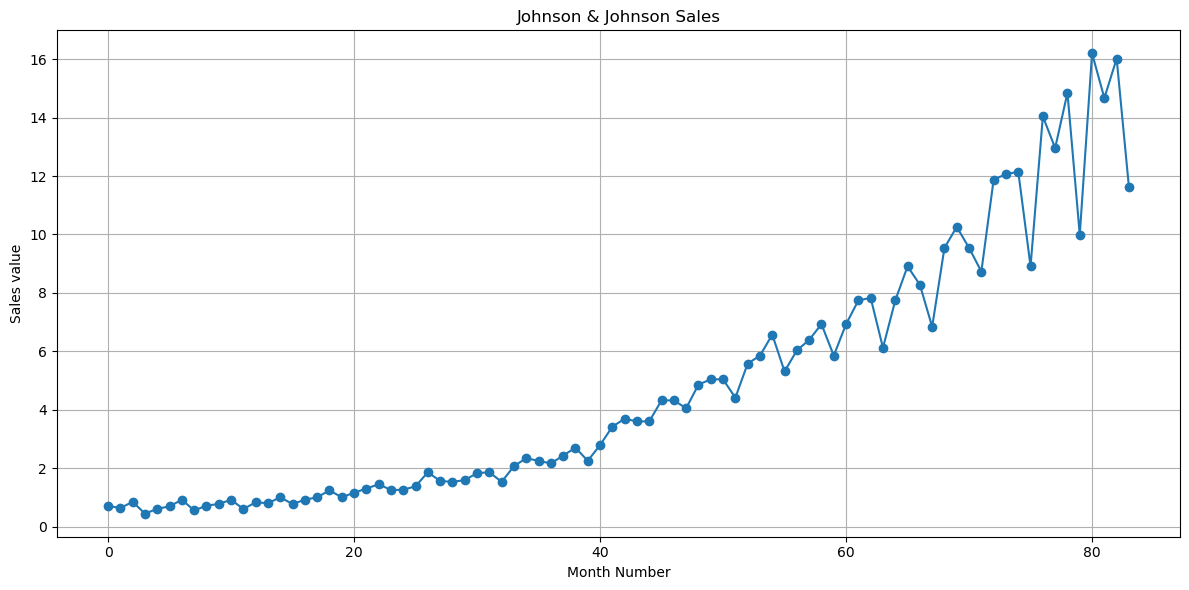

In [167]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['data'], marker='o')
plt.title('Johnson & Johnson Sales')
plt.xlabel('Month Number')
plt.ylabel('Sales value')
plt.grid(True)
plt.tight_layout()
plt.show()

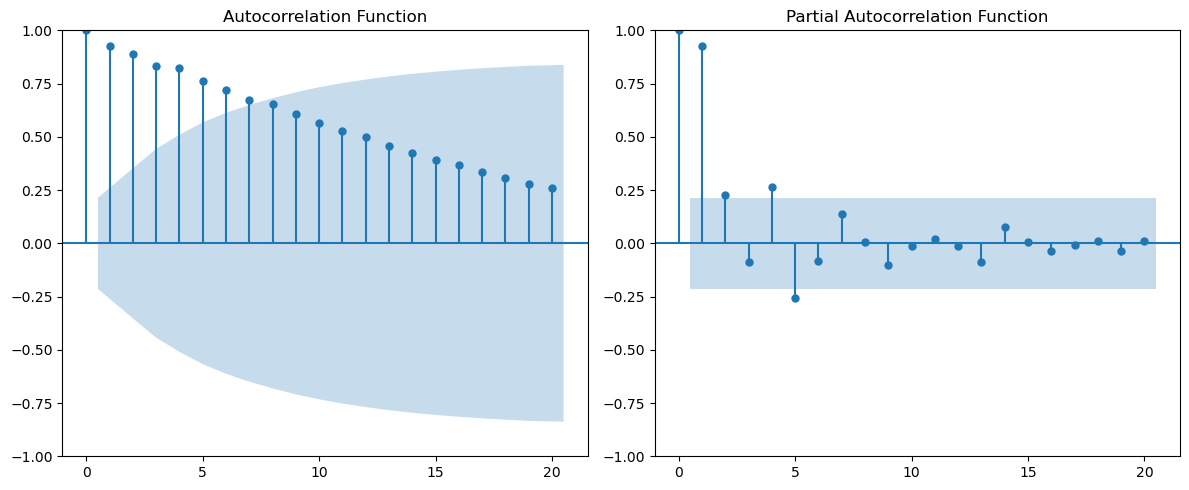

In [168]:
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(data['data'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(data['data'], ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [169]:
# Perform ADF test
result = adfuller(data['data'])

# Print results
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])


ADF Test Statistic: 2.742016573457468
p-value: 1.0


In [170]:
# take the log()

data['data_log'] = np.log(data['data'])

# then take the first difference
data['data_tr_1'] = data['data_log'].diff()

data.head(10)

,date,data,data_log,data_tr_1
0,1960-01-01,0.71,-0.342490,NaN
1,1960-04-01,0.63,-0.462035,-0.119545
2,1960-07-02,0.85,-0.162519,0.299517
3,1960-10-01,0.44,-0.820981,-0.658462
4,1961-01-01,0.61,-0.494296,0.326684
5,1961-04-02,0.69,-0.371064,0.123233
6,1961-07-02,0.92,-0.083382,0.287682
7,1961-10-01,0.55,-0.597837,-0.514455
8,1962-01-01,0.72,-0.328504,0.269333
9,1962-04-02,0.77,-0.261365,0.067139


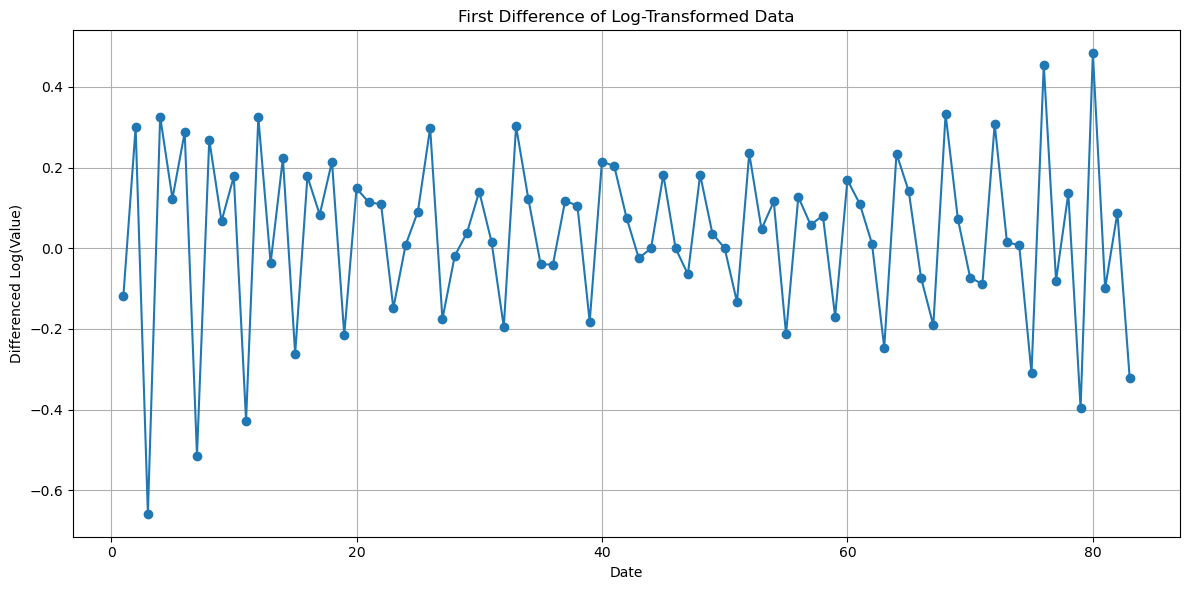

In [171]:
# Plot the differenced log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(data['data_tr_1'], marker='o')
plt.title('First Difference of Log-Transformed Data')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Value)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [173]:
# Drop NA values before ADF test
adf_result = adfuller(data['data_tr_1'].dropna())

# Print ADF test results
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])



ADF Test Statistic: -4.317043945811826
p-value: 0.0004149731404440838


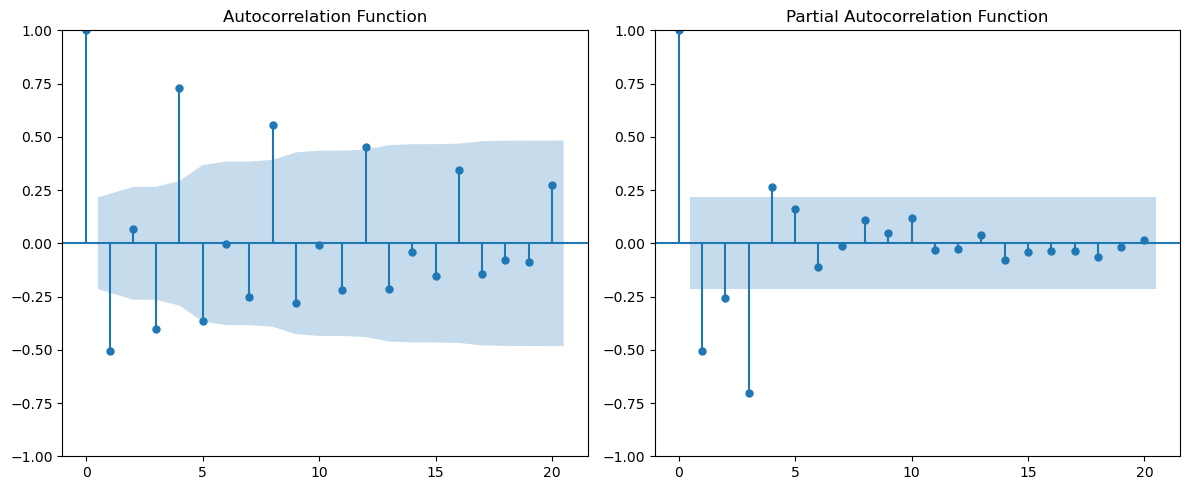

In [174]:
# Drop NA values
series = data['data_tr_1'].dropna()
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(series, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(series, ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [175]:
# I have used tqdm_notebook here to add a progress bar when the script is running

def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable, in this case data['data']
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            #model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
        except:
            continue
            
        aic = model_fit.aic
        results.append([order, model_fit.aic])
        #print(order)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [176]:
# in this example, I do the order up to p=q=8


ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

    
# print out the first few rows of order_list to check it looks right
order_list[:10]



[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [180]:
# call opitimize_ARIMA

result_df = optimize_ARIMA(data['data'], order_list)


# print out the ordered list. The best model fit (lowest AIC) will be shown at the top
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.499079
1,"(4, 1, 6)",115.859346
2,"(7, 1, 1)",116.050993
3,"(5, 1, 3)",116.535767
4,"(5, 1, 4)",117.242710
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [189]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


from pmdarima.model_selection import train_test_split
train, test = train_test_split(data['data'], train_size=82)

model = pm.auto_arima(train, seasonal=False, m=1, test='adf',max_p=6, max_q=6)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -46.634
Date:                Fri, 11 Apr 2025   AIC                            113.268
Time:                        05:46:20   BIC                            137.212
Sample:                             0   HQIC                           122.875
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4654      0.142    -10.350      0.000      -1.743      -1.188
ar.L2         -0.7419      0.159     -4.678      0.000      -1.053      -0.431
ar.L3          0.0390      0.075      0.521      0.6

In [192]:

from statsmodels.tsa.arima.model import ARIMA

# p,d,q ARIMA Model
best_model = ARIMA(data['data'], order=(6,1,3))

best_model_fit = best_model.fit()

In [193]:
#summary of the model
print(best_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.750
Date:                Fri, 11 Apr 2025   AIC                            115.499
Time:                        05:47:42   BIC                            139.687
Sample:                             0   HQIC                           125.217
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4420      0.123    -11.685      0.000      -1.684      -1.200
ar.L2         -0.7324      0.147     -4.983      0.000      -1.020      -0.444
ar.L3          0.0448      0.063      0.714      0.4

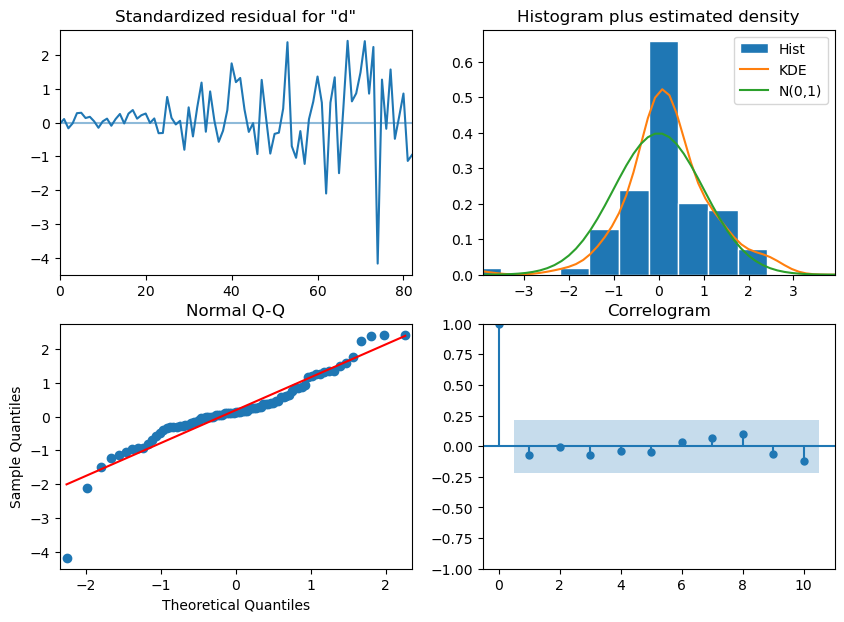

In [194]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [195]:
#get prediction start and end dates
test_data = data['data']

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

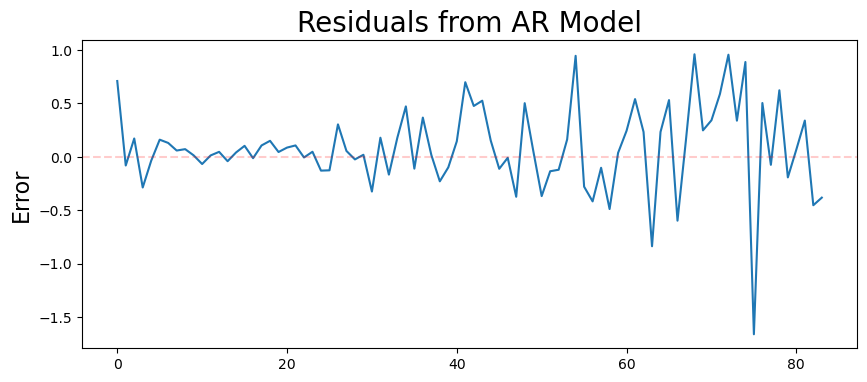

In [196]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

In [198]:
# Assess the root mean square of the residuals

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.4014519180598638


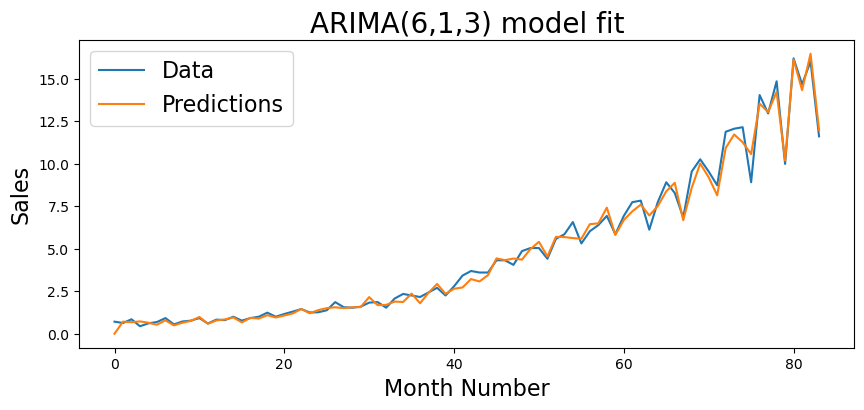

In [200]:
# Plot the model prediction against the data

plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('ARIMA(6,1,3) model fit', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)
plt.show()

In [205]:
def forecast_accuracy(forecast, actual):
    # Convert to NumPy arrays in case they're Pandas Series
    forecast = np.array(forecast)
    actual = np.array(actual)

    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # Correlation

    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)           # MinMax

    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'corr': corr,
        'minmax': minmax
    }


In [206]:
metrics = forecast_accuracy(predictions, test_data)
print(metrics)


{'mape': 0.08953174692770698, 'me': -0.08212304061317352, 'mae': 0.27978918370673084, 'mpe': -0.028306925300629584, 'rmse': 0.4014519180598638, 'corr': 0.9957906520720566, 'minmax': 0.08447863354817342}


In [207]:
# use get_forecast() for this

# make the predictions for 24 steps ahead
predictions_int = best_model_fit.get_forecast(steps=26)
predictions_int.predicted_mean

84     17.318008
85     16.505319
86     17.146921
87     13.404121
88     18.879281
89     17.830380
90     18.667666
91     14.994480
92     20.416802
93     19.301742
94     19.982448
95     16.760702
96     21.824003
97     20.796382
98     21.345389
99     18.427688
100    23.309560
101    22.217110
102    22.743642
103    20.084013
104    24.755913
105    23.668827
106    24.112733
107    21.744856
108    26.188342
109    25.105267
Name: predicted_mean, dtype: float64

In [208]:
# get a better view
predictions_int.conf_int()

,lower data,upper data
84,16.540113,18.095902
85,15.701993,17.308644
86,16.278358,18.015484
87,12.534876,14.273366
88,17.452122,20.306440
89,16.377447,19.283313
90,17.109555,20.225777
91,13.407733,16.581227
92,18.414340,22.419264
93,17.224678,21.378805


In [209]:
# add the predicted mean column in

conf_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

conf_df.head()

,predicted_mean,lower data,upper data
84,17.318008,16.540113,18.095902
85,16.505319,15.701993,17.308644
86,17.146921,16.278358,18.015484
87,13.404121,12.534876,14.273366
88,18.879281,17.452122,20.306440


In [210]:
# change the name of the column heads

conf_df = conf_df.rename(columns={'predicted_mean': 'Predictions', 'lower data': 'Lower CI', 'upper data': 'Upper CI'})
conf_df.head()

,Predictions,Lower CI,Upper CI
84,17.318008,16.540113,18.095902
85,16.505319,15.701993,17.308644
86,17.146921,16.278358,18.015484
87,13.404121,12.534876,14.273366
88,18.879281,17.452122,20.306440


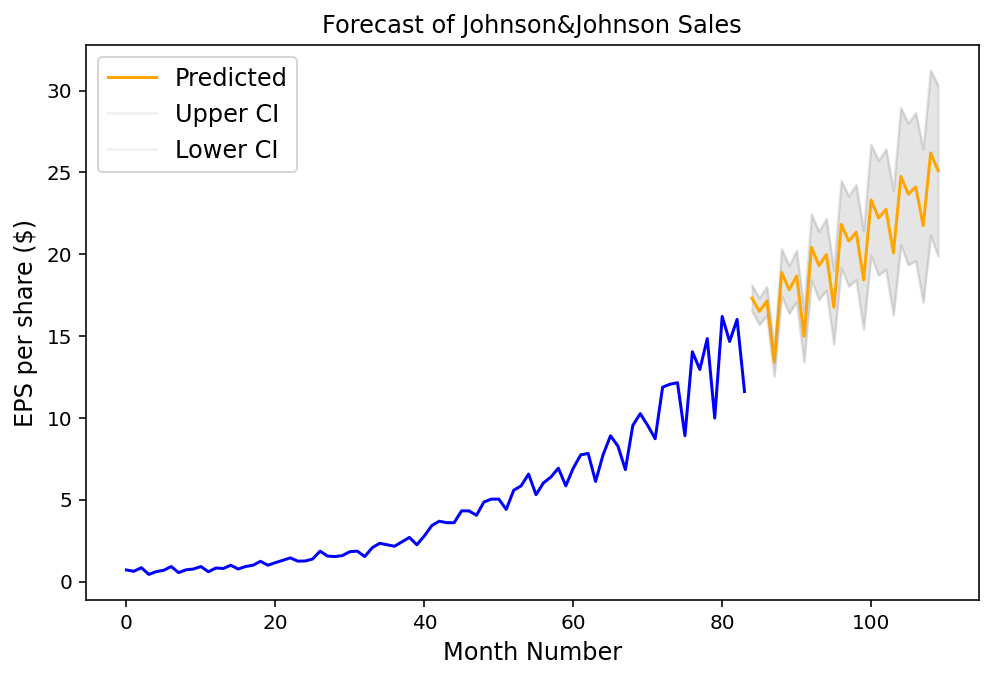

In [211]:
# make a plot of model fit
# color = 'dodgeblue'

#fig = plt.figure(figsize = (8,5), dpi=144)
#ax1 = fig.add_subplot(111)



fig, ax = plt.subplots(figsize = (8,5), dpi=144)
ax.plot(data['data'], 'b')
#ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Sales')


x = conf_df.index.values


upper = conf_df['Upper CI']
lower = conf_df['Lower CI']


conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI', alpha=0.1)
lower.plot(color = 'grey', label = 'Lower CI', alpha=0.1)

# fill between the conf intervals
ax.fill_between(x, lower, upper, color='grey', alpha=0.2)

plt.ylabel('EPS per share ($)', fontsize=12)
plt.xlabel('Month Number', fontsize=12)

plt.legend(loc = 'upper left', fontsize = 12)


plt.show()